In [1]:
import argparse
import pickle
from collections import namedtuple

import matplotlib.transforms as trs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import patches
from matplotlib import animation
from IPython.display import HTML
# install package for displaying animation
!pip install JSAnimation

%matplotlib inline

import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler


  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11425 sha256=ce32a23206a814f40af16ba17e15938dce1eb85e5a50bd0fb1164d96d427b30f
  Stored in directory: /root/.cache/pip/wheels/0e/4e/3d/05fb8cca2646ee0bbfbce17c40a970f48d5e0698b9e5aaa91f
Successfully built JSAnimation


# Hyper-Parameters

In [7]:
gamma=0.9
seed=0
render=True
log_interval=100
T = 200
num_H = 0
num_O = 4 + num_H * 2
num_A = 2

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

# Neural Networks

In [5]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(num_O, 100)
        self.mu_head = nn.Linear(100, num_A)
        self.sigma_head = nn.Linear(100, num_A)

    def forward(self, x):
        x = F.relu(self.fc(x))
        mu = torch.tanh(self.mu_head(x))
        sigma = F.softplus(self.sigma_head(x))
        mu = torch.clamp(mu, 1e-10)
        sigma = torch.clamp(sigma, 1e-10)
        return (mu, sigma)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(num_O, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        state_value = self.v_head(x)
        return state_value

# Agent

In [6]:
class Agent():

    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 128

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        action.clamp(-2.0, 2.0)
        return action.view(-1).numpy(), action_log_prob.view(-1).numpy()

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def save_param(self):
        torch.save(self.anet.state_dict(), 'param/ppo_anet_params.pkl')
        torch.save(self.cnet.state_dict(), 'param/ppo_cnet_params.pkl')

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.cat([torch.from_numpy(t.a.reshape(1,2)) for t in self.buffer], dim=0)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.cat(
            [torch.from_numpy(t.a_log_p.reshape(1,2)) for t in self.buffer], dim=0).view(-1, 2)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()

                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [19]:
class RobotEnv(gym.Env):
  def __init__(self,):
    self.sT = np.array([0., 5.])
    self.s0 = np.array([0., -5.])

  def step(self, action):
    v, r = action[0], action[1]
    px, py = self.state
    self.theta += r
    px = px + v * np.cos(self.theta[0])
    py = py + v * np.sin(self.theta[0])

    self.state = np.array([px, py])

    dist = np.linalg.norm(self.sT - self.state)
    if dist < 0.5: 
      cost = 10
      done = True
    else: 
      cost = -1*dist
      done = False

    return self._get_obs(), cost, done, {}

  def _get_obs(self):
    dist = self.sT - self.state
    heading = np.array([np.cos(self.theta[0]), np.sin(self.theta[0])])
    return np.hstack([dist, heading])
    
  def reset(self):
    self.state = self.s0
    self.theta = np.array([np.pi / 2])
    return self._get_obs()

  def render(self, path):
    # if self.fig == None:
    self.fig, self.ax = plt.subplots(figsize=(7, 7))
    robot = plt.Circle(self.state, 0.5, fill=True, color='y')
    self.ax.add_artist(robot)

    robot.center = self.state

    self.ax.scatter(path[:, 0],path[:,1])
    self.ax.add_artist(mlines.Line2D([self.sT[0]],[self.sT[1]], color='r', marker='*', linestyle='None', markersize=15, label='Goal'))

    vertices =[(-1/4,0), (1/4,0), (0, 1/2)] 
    polygon = patches.Polygon(vertices, color="red", alpha=0.50) 
    self.ax.add_artist(polygon)
    r = trs.Affine2D().rotate(self.theta[0]-np.pi/2)
    t = trs.Affine2D().translate(self.state[0], self.state[1])
    tra = r + t + self.ax.transData
    polygon.set_transform(tra)

    self.ax.scatter(self.s0[0], self.s0[1], marker='o', c='y')
    # self.ax.set_title(f'time={self.t}')
    self.ax.set_xlabel('x(m)', fontsize=16)
    self.ax.set_ylabel('y(m)', fontsize=16)
    self.ax.set_xlim(-7, 7)
    self.ax.set_ylim(-7, 7)
    plt.show()

# Training

Ep 0	 Score: -3517.56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Ep 100	 Score: -1314.02
Ep 200	 Score: -1077.00
Ep 300	 Score: -802.45
Ep 400	 Score: -58.61
Ep 500	 Score: -50.14
Ep 600	 Score: -51.60
Ep 700	 Score: -123.26
Ep 800	 Score: -62.93
Ep 900	 Score: -30.43


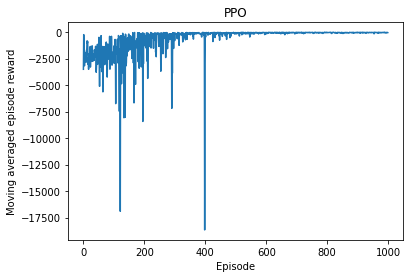

In [11]:
env = RobotEnv()
env.seed(seed)

agent = Agent()

training_records = []
state = env.reset()

for i_ep in range(1000):
    score = 0
    state = env.reset()

    for t in range(T):
        action, action_log_prob = agent.select_action(state)
        state_, reward, done, _ = env.step(action)
        if agent.store(Transition(state, action, action_log_prob, reward, state_)):
          agent.update()
        score += reward
        state = state_
        if done:
          break

    training_records.append(TrainingRecord(i_ep, score))

    if i_ep % log_interval == 0:
        print(f'Ep {i_ep}\t Score: {score:.2f}')

plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()


# Testing (video)

In [21]:
env = RobotEnv()
state = env.reset()
traj = []
thetas = []

for t in range(T):
    traj.append(env.state.copy())
    thetas.append(env.theta[0].copy())
    action, action_log_prob = agent.select_action(state)
    state_, reward, done, _ = env.step(action)
    # env.render(np.asarray(traj))
    state = state_


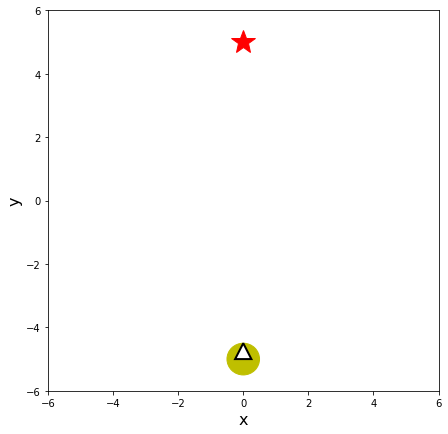

In [23]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

# set up the subplots as needed
ax.set_xlim(( -6, 6))            
ax.set_ylim((-6, 6))
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)

txt_title = ax.set_title('')
ax.add_artist(mlines.Line2D([0],[5], color='r', marker='*', linestyle='None', markersize=25, label='Goal'))
robot = plt.Circle(traj[0], 0.5, fill=True, color='y')
ax.add_artist(robot)

vertices =[(-1/4,0), (1/4,0), (0, 1/2)] 
polygon = patches.Polygon(vertices, fc=(1,1,1,1), ec=(0,0,0,1), lw=2) 
ax.add_artist(polygon)
r = trs.Affine2D().rotate(thetas[0]-np.pi/2)
t = trs.Affine2D().translate(traj[0][0], traj[0][1])
tra = r + t + ax.transData
polygon.set_transform(tra)

line1, = ax.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax.plot([], [], 'r', lw=2)

In [30]:
def drawframe(n, path, thetas):
    robot.center = path[n]
    r = trs.Affine2D().rotate(thetas[n]-np.pi/2)
    t = trs.Affine2D().translate(path[n][0], path[n][1])
    tra = r + t + ax.transData
    polygon.set_transform(tra)
    txt_title.set_text('Frame = {0:4d}'.format(n))
    line1.set_data(path[:n, 0], path[:n, 1])
    return (line1,line2)

anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=100, blit=True, fargs=(np.asarray(traj), thetas))
HTML(anim.to_html5_video())